# This Notebook will primarily concern itself with methods used to transform the data into a form and with features that are useful for time series forecasting

## This will primarily be manipulation through pandas, with the data being reinserted into the CassDB under a new, manipulated table

In [1]:
import pandas as pd #A great way to start your codeblock
#Establish a Cluster object that will connect to the cassandra keyspace
from cassandra.cqlengine import connection
from cassandra.cluster import Cluster
from cassandra.cqlengine.management import sync_table
connection.setup(['127.0.0.1'],"sp500",protocol_version=3)
cluster = Cluster()
session = cluster.connect('sp500')
#Import the ORM Model to later import derived data
from cassandra.cqlengine.models import Model
from cassandra.cqlengine import columns
#Let's try to query something simple out
# I'll use the dictionary factory to make it play nice with pandas
from cassandra.query import dict_factory
session.row_factory = dict_factory
result = session.execute("select * from raw_data WHERE ticker = 'AAPL';")
raw_df = pd.DataFrame.from_dict(result)
raw_df.shape #There are about ~250 trading days per year, so we expect ~1250 days from 5 years of data

(1258, 14)

In [2]:
df_sorted = raw_df.sort_values('date')
df_sorted = df_sorted.reset_index()
df_sorted.head()

,index,change,changeOverTime,changePercent,close,date,high,id,label,low,open,ticker,unadjustedVolume,volume,vwap
0,805,-0.040710,0.000000,-0.058,69.663696,2014-03-07,69.865898,fd320f58-4094-11e9-9968-107b44927731,"Mar 7, 14",69.087097,69.749100,AAPL,7916463,55415241,69.484398
1,838,0.063038,0.000904,0.090,69.726700,2014-03-10,70.043198,fd3284ae-4094-11e9-a17a-107b44927731,"Mar 10, 14",69.387802,69.390503,AAPL,6384490,44691430,69.785698
2,729,0.678987,0.010651,0.974,70.405701,2014-03-11,70.753700,fd3320dc-4094-11e9-b978-107b44927731,"Mar 11, 14",69.945999,70.321701,AAPL,10028407,70198849,70.484802
3,240,0.068289,0.011632,0.097,70.473999,2014-03-12,70.571198,fd33e492-4094-11e9-b7b9-107b44927731,"Mar 12, 14",69.868599,70.198196,AAPL,7170780,50195460,70.286400
4,918,-0.782734,0.000396,-1.111,69.691299,2014-03-13,70.874603,fd34a7ec-4094-11e9-bae1-107b44927731,"Mar 13, 14",69.495598,70.583000,AAPL,9205087,64435609,70.101303


In [3]:
import matplotlib
plot = df_sorted.plot(x='date',y='close')

In [4]:
df_sorted['close'].describe()

count    1258.000000
mean      129.459866
std        38.062601
min        68.024696
25%       101.089825
50%       116.551903
75%       157.937450
max       230.275406
Name: close, dtype: float64

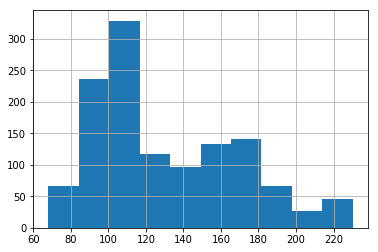

In [5]:
df_sorted['close'].hist()

In [6]:
#Create training and testing df's
training_cut = int(df_sorted.shape[0] * 0.7)
training_df = df_sorted.iloc[0:training_cut]
testing_df = df_sorted.iloc[training_cut:]
testing_df.head()

,index,change,changeOverTime,changePercent,close,date,high,id,label,low,open,ticker,unadjustedVolume,volume,vwap
880,1091,0.048875,1.301869,0.030,160.356705,2017-09-01,161.226700,ff58fe92-4094-11e9-9d46-107b44927731,"Sep 1, 17",159.946198,161.089798,AAPL,16591051,16591051,160.426300
881,1034,-1.925700,1.274227,-1.201,158.431107,2017-09-05,160.552200,ff59c1e8-4094-11e9-ab3a-107b44927731,"Sep 5, 17",156.945297,160.063507,AAPL,29536314,29536314,158.716904
882,13,-0.166173,1.271842,-0.105,158.264893,2017-09-06,159.320602,ff5a5db4-4094-11e9-84e4-107b44927731,"Sep 6, 17",156.906204,159.046906,AAPL,21651726,21651726,158.109100
883,338,-0.635365,1.262721,-0.401,157.629501,2017-09-07,158.587494,ff5b2192-4094-11e9-b192-107b44927731,"Sep 7, 17",156.749802,158.440796,AAPL,21928502,21928502,157.765396
884,167,-2.570800,1.225818,-1.631,155.058701,2017-09-08,157.522003,ff5be4ee-4094-11e9-a18a-107b44927731,"Sep 8, 17",154.960999,157.238495,AAPL,28611535,28611535,155.943298


In [16]:
from statsmodels.tsa.arima_model import ARIMA
def fit_random_walk(training_series,p=0,d=1,q=0):
    model = ARIMA(training_series,order=(p,d,q))
    model_fit = model.fit()
    return model_fit

def forecast(ARIMA_model_fit,steps_out):
    model_fit = ARIMA_model_fit
    prediction = model_fit.forecast(steps=steps_out)
    return prediction[0]

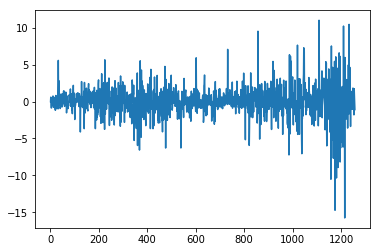

In [33]:
from matplotlib import pyplot as plt
model_fit = fit_random_walk(df_sorted['close'])
list_of_actuals = []
list_of_dates = []
plt.plot(model_fit.resid)

# actual_close = testing_df['close'].iloc[i]
# date = testing_df['date'].iloc[i]
# predicted_close = forecast(model_fit,1)
# list_of_actuals.append(actual_close)
# list_of_dates.append(date)

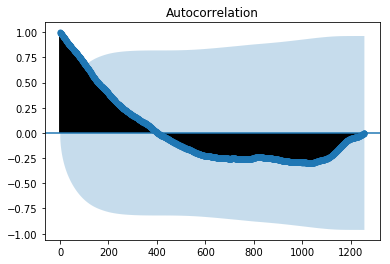

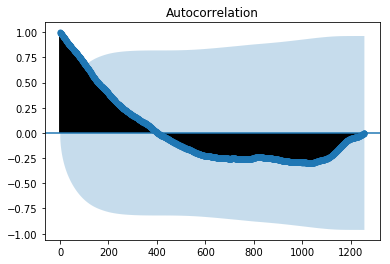

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_sorted['close'])

In [42]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2734.660
Method:                           css   S.D. of innovations              2.131
Date:                Wed, 17 Apr 2019   AIC                           5473.321
Time:                        08:32:45   BIC                           5483.594
Sample:                             1   HQIC                          5477.182
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0834      0.060      1.388      0.165      -0.034       0.201
==============================================================================
"""